<H3>Trabalho Prático 1 - Algoritmos 2 2024.1 UFMG</H3>
Membros:

* Gabriel Arcanjo Campelo Fadoul - 2021031645

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from TriangProntaAlterada import *

<H4> Carga das instâncias de testes

In [2]:
with open("instances\\agp2009a-orthorand\\agp2009a-orthorand\\random-20-1.pol") as f:
    line = f.readline()
    file_values = line.split()
total_vertices = int(file_values[0])

G = Grafo()

#Adiciona Vértices no Grafo
V = []
for i in range(1,len(file_values),2):
    X, Y = file_values[i], file_values[i+1]
    
    a, b = X.split("/")
    coord_x = float(a) / float(b)
    
    a, b = Y.split("/")
    coord_y = float(a) / float(b)
    
    V.append(Vertice(coord_x, coord_y))
    G.adicionar_vertice(Vertice(coord_x, coord_y))

# Adiciona Arestas no Grafo
for i in range(len(V)-1):
    G.adicionar_aresta(Aresta(G.vertices[i],G.vertices[i+1]))
G.adicionar_aresta(Aresta(G.vertices[len(V)-1],G.vertices[0]))

In [3]:
#df = px.data.gapminder()
v = list(map(lambda P: (P.x,P.y),V))
fig = go.Figure(
        data = [go.Scatter(x=np.array(v)[:,0],y=np.array(v)[:,1])]
                )
#fig.update_traces(marker_size=10)
fig.show()

<H4>Funções Primitivas de Geometria Computacional

<H4>Funções de Triangulação

<H4>Animações

In [4]:
#df = px.data.gapminder()
v = list(map(lambda P: (P.x,P.y),G.vertices))


fig = px.line(x=np.array(v)[:,0],y=np.array(v)[:,1],markers=True)
fig.update_traces(marker_size=10)
#fig.update_traces(marker=dict(size=100,
#                              line=dict(width=2,
#                                        color='DarkSlateGrey')),
#                  selector=dict(mode='markers'))
fig.show()

In [5]:
(G, triangulos) = triangulacao(G)
#plot_custom_polygon(G.graph, G.vertices, G.arestas)

In [6]:
def color_triangle(graph, triangulos, i):
    colors = [0, 1, 2]
    if i == 0:
        p1,p2,p3 = triangulos[i]
        graph.nodes[p1]['color'] = colors[0]
        graph.nodes[p2]['color'] = colors[1]
        graph.nodes[p3]['color'] = colors[2]
        return graph

    ja_coloridos = dict()
    point = 0
    for p in triangulos[i]:
        if graph.nodes[p]['color'] != None:
            ja_coloridos[p] = graph.nodes[p]['color']
        else:
            point = p    
            
    to_color = list((set(colors) - (set(ja_coloridos.values()) & set(colors))))[0]
    graph.nodes[point]['color'] = to_color
    
    return graph



In [7]:
colored_Graph = G.graph.copy()

dual = nx.Graph()
for i in range(len(triangulos)):
    tri_v = '-'.join(np.array(triangulos[i],dtype=str))
    dual.add_node(i,tri_v = tri_v)

for i in range(len(triangulos)):
    for j in range(len(triangulos)):
        if(len(set(triangulos[i]+triangulos[j]))) == 4:
            dual.add_edge(i,j)

dfs_edges = list(nx.dfs_edges(dual))
colored_Graph = color_triangle(colored_Graph,triangulos,0)
for i,j in dfs_edges:
    colored_Graph = color_triangle(colored_Graph,triangulos,j)

In [8]:
colors  = list(nx.get_node_attributes(colored_Graph,'color').values())

In [9]:
def plot_custom_polygon_2(G, vertices, arestas, coloracao):
    fig, ax = plt.subplots()
    # Pega as posições dos nós
    pos = nx.get_node_attributes(G, 'pos')

    # Define um mapa de cores para as 3 cores
    cores = ['cyan', 'magenta', 'yellow']  # Pode ajustar as cores conforme necessário

    # Desenha o grafo com as cores especificadas na coloração
    node_colors = [cores[coloracao[i]] for i in range(len(vertices))]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='r', node_size=500, font_size=12, font_color='black')

    # Desenha apenas os segmentos de arestas definidos
    for ar in arestas:
        x_values = [ar.pInicio.x, ar.pFinal.x]
        y_values = [ar.pInicio.y, ar.pFinal.y]
        ax.plot(x_values, y_values, 'r-')

    # Ajusta os limites do gráfico
    ax.set_xlim(min(v.x for v in vertices) - 1, max(v.x for v in vertices) + 1)
    ax.set_ylim(min(v.y for v in vertices) - 1, max(v.y for v in vertices) + 1)
    ax.set_aspect('equal')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Custom Polygon')
    plt.grid(True)

    plt.show()

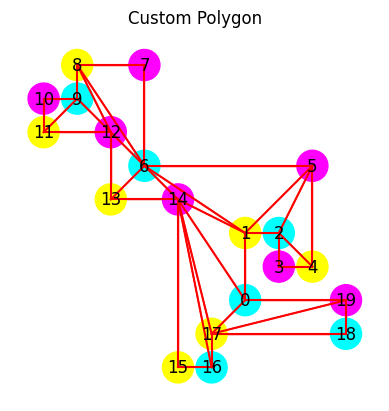

In [10]:
plot_custom_polygon_2(colored_Graph, G.vertices, G.arestas, colors)